### Mount Google Drive in Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing necessary libraries

 Importing the necessary libraries and downloading the things needed to build the model.

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from collections import Counter
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.models import load_model, save_model
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read the dataset.

The dataset is read using pandas library. The data is in csv format. It has two columns- review and sentiment. 'Review' column contains the movie reviews and 'Sentiment' column contains their respective sentiments labelled as postive and negative. The dataframe contains a total of 50000 reviews.

In [3]:
data=pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

In [4]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


The dataset is balanced as it conatains same number of positive and negative reviews. This helps the model to predict the sentiment without biased.

In [5]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

### Data Preprocessing

Missing values and duplicates are checked. There is no missing values in the dataset. But there are some duplicate entries, which are deleted.

In [6]:
data.isna().sum()

review       0
sentiment    0
dtype: int64

In [7]:
data['review'].duplicated().sum()

418

In [8]:
data = data.drop_duplicates('review')

The positive and negative labelling of sentiments are replaced with 1 and 0 respectively, which is helpful in model building.

In [9]:
data.sentiment.replace("positive", 1, inplace=True)
data.sentiment.replace("negative", 0, inplace=True)

<ipython-input-9-e6096e533207>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sentiment.replace("positive", 1, inplace=True)
<ipython-input-9-e6096e533207>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sentiment.replace("negative", 0, inplace=True)


A function called data preprocessing is created. This function is used to clean and prepare raw text data for analysis. It normalizes the text by converting it to lowercases,ensuring uniformity in word representations. It removes irrelevant or noisy elements like HTML tags,URLs and so on. It also split the text into individual words or tokens, making it ready for analysis.

In [10]:
stop_words = set(stopwords.words('english'))

In [11]:
def data_processing(text):
    text = text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^\w\s]','', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [12]:
data.review = data['review'].apply(data_processing)

<ipython-input-12-abd04eb9e5e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.review = data['review'].apply(data_processing)


In [13]:
data

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49995,thought movie right good job wasnt creative or...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary schools n...,0
49998,im going disagree previous comment side maltin...,0


Porter stemming is used to normalize words in text data by reducing them to thier root or base form. This helps in treating different forms of a word as the same, dimensionality reduction,improving analysis and efficient information retrieval.

In [14]:
stemmer = PorterStemmer()

def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data


In [15]:
data.review = data['review'].apply(lambda x: stemming(x))
data.head()

<ipython-input-15-80286e8f977f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.review = data['review'].apply(lambda x: stemming(x))


,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1


In [69]:
pos_reviews = data[data.sentiment ==1]
neg_reviews=data[data.sentiment==0]

In [70]:
count = Counter()
for text in pos_reviews['review'].values:
    for word in text.split():
        count[word] += 1
count.most_common(15)

[('film', 39285),
 ('movie', 35836),
 ('one', 25621),
 ('like', 16999),
 ('good', 14286),
 ('great', 12570),
 ('story', 12338),
 ('see', 11814),
 ('time', 11724),
 ('well', 10933),
 ('really', 10641),
 ('also', 10517),
 ('would', 10320),
 ('even', 9319),
 ('much', 8971)]

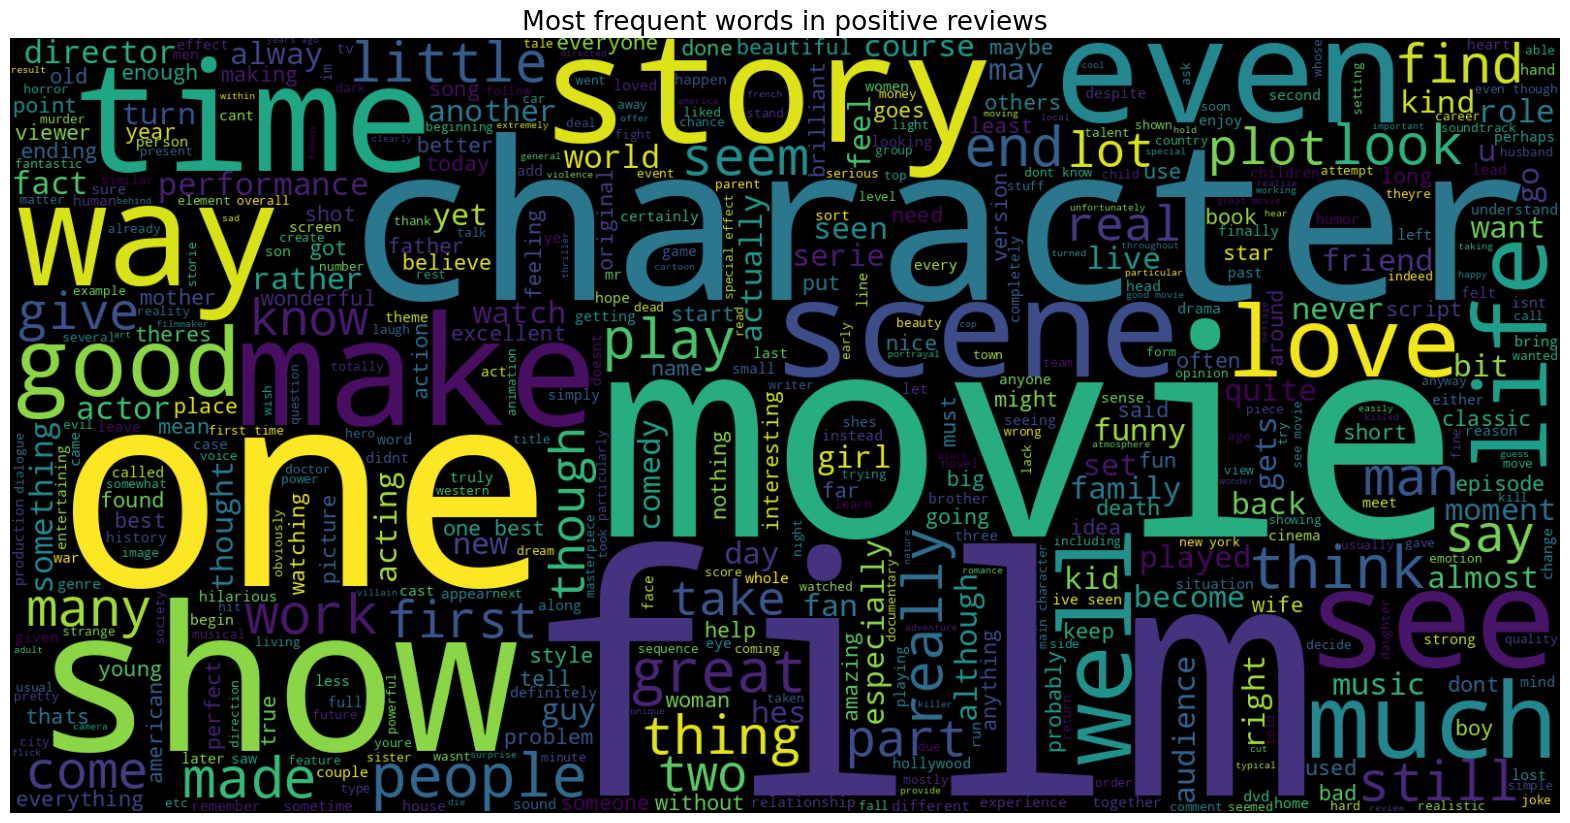

In [78]:
text = ' '.join([word for word in pos_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

In [73]:
for text in neg_reviews['review'].values:
    for word in text.split():
        count[word] += 1
count.most_common(15)

[('movie', 82847),
 ('film', 73936),
 ('one', 49985),
 ('like', 38508),
 ('good', 28283),
 ('even', 24080),
 ('would', 23803),
 ('time', 23074),
 ('really', 22725),
 ('see', 22227),
 ('story', 21902),
 ('much', 18730),
 ('well', 18306),
 ('get', 18035),
 ('great', 17596)]

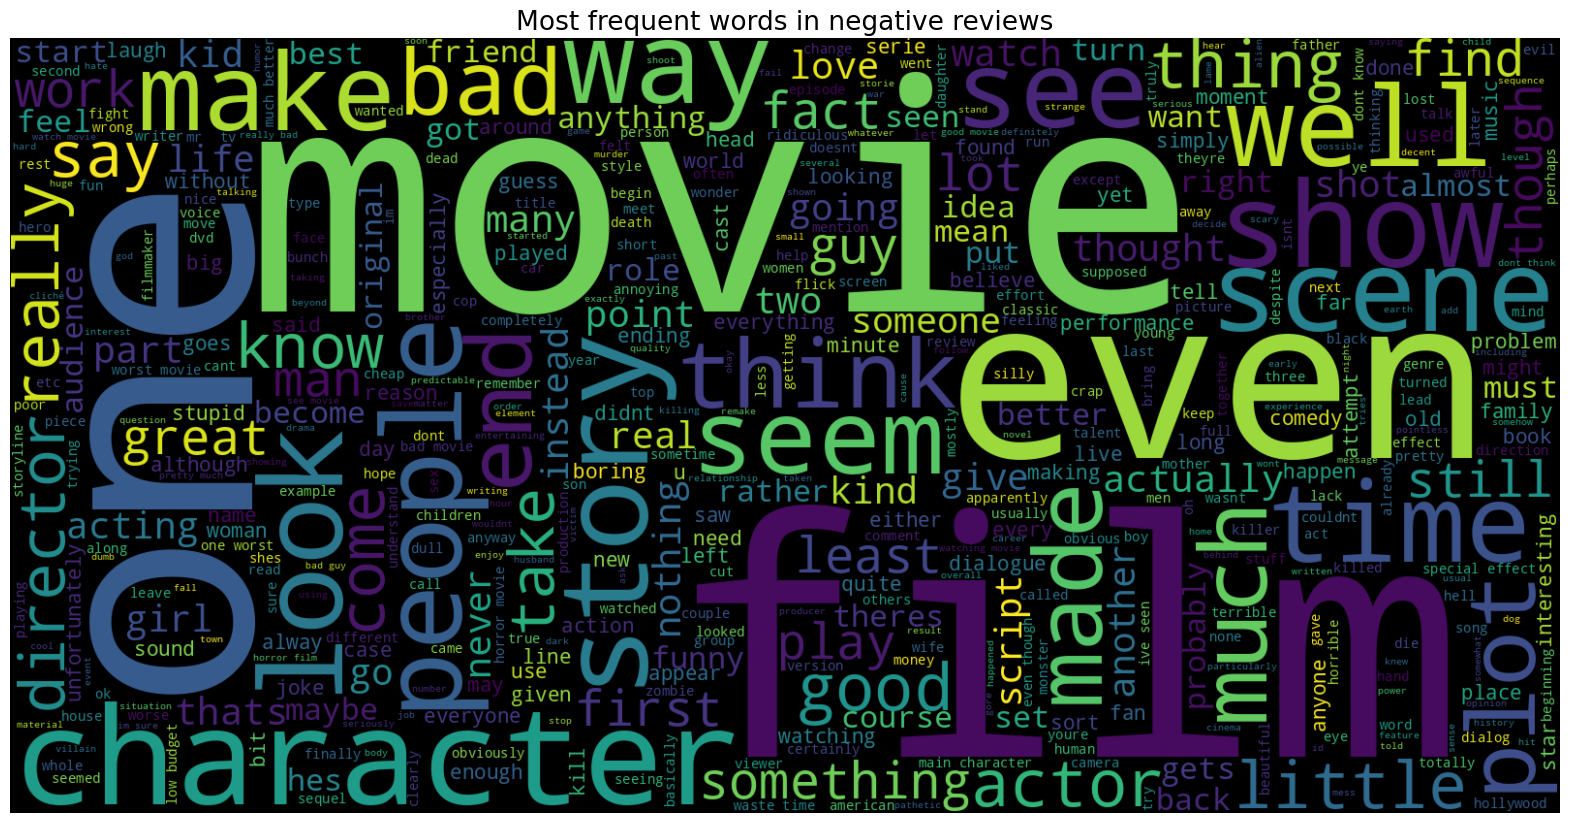

In [77]:
text = ' '.join([word for word in neg_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative reviews', fontsize = 19)
plt.show()

These line of codes separated the data into two variables, X and Y. X typically represents the independent variables while Y represents the target or depenedent variables.

In [16]:
X = data['review']
Y = data['sentiment']

TfidVectorizer is used to convert a collection of text documents into a matrix of numerical features. it calculates the TF-IDF values for words in the text. It helps in dimensionality reduction and enhancing text analysis.

In [17]:
vect = TfidfVectorizer()
X = vect.fit_transform(data['review'])

Data splitting: It is used to split dataset into training and testing subsets. 30% of the data are taken as test data and remaining as train data.It is essential for model evaluation.

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [19]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (34707, 221707)
Size of y_train:  (34707,)
Size of x_test:  (14875, 221707)
Size of y_test:  (14875,)


In [20]:
x_train = x_train[:2000]
y_train = y_train[:2000]
x_test = x_test[:500]
y_test = y_test[:500]

In [21]:
x_train = x_train.toarray()
x_test = x_test.toarray()

### Model Building

The code below defines a neural network model using Keras library. 'Sequential' is a type of Keras model that allows you to create a feedforawrd neural network in a sequential manner. The code adds three layers to the model.

In [22]:
model = Sequential()
model.add(Dense(units=16, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

Model Compilation: It is used to configure the training process for a neural network model. It takes 'adam' as the optimizer and defines binary cross entropy as the loss function. It sets accuracy as the evaluation metric for training.

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model training: It is used to train neural network model. It defines the size of mini-batches used during training. The model's weights are updated after processing each mini-batch. It updates the model's weights to minimize the defined loss function and improve its ability to make accurate predictions.

In [24]:
history = model.fit(x_train, y_train, batch_size=10, epochs=8)

Epoch 1/8
200/200 [==============================] - 10s 47ms/step - loss: 0.6380 - accuracy: 0.7695
Epoch 2/8
200/200 [==============================] - 13s 63ms/step - loss: 0.2308 - accuracy: 0.9735
Epoch 3/8
200/200 [==============================] - 11s 53ms/step - loss: 0.0351 - accuracy: 0.9965
Epoch 4/8
200/200 [==============================] - 9s 44ms/step - loss: 0.0093 - accuracy: 1.0000
Epoch 5/8
200/200 [==============================] - 10s 49ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 6/8
200/200 [==============================] - 11s 57ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 7/8
200/200 [==============================] - 9s 44ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 8/8
200/200 [==============================] - 12s 61ms/step - loss: 8.4950e-04 - accuracy: 1.0000


Model Summary: Viewing the model summary is useful to understand the architecture and complexity of the neural network. It provides insights into the number of parameters and layers in the model.

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                3547328   
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3547473 (13.53 MB)
Trainable params: 3547473 (13.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model Evaluation: The provided code is used to evaluate the performance of a trained neural network model on a separate test dataset. The test loss (often using the same loss function as during training) quantifies how well the model's predictions match the actual labels on the test data. The test accuracy indicates the proportion of correct predictions made by the model on the test set.

In [26]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

16/16 [==============================] - 1s 35ms/step - loss: 0.4062 - accuracy: 0.8540
Test loss: 0.4062003195285797
Test accuracy: 0.8539999723434448


The grapgh below shows that the training loss decreases as the epoch value increases and training accuracy increases rapidly with increase in epoch value and reaches the maximum value at 4th epoch.

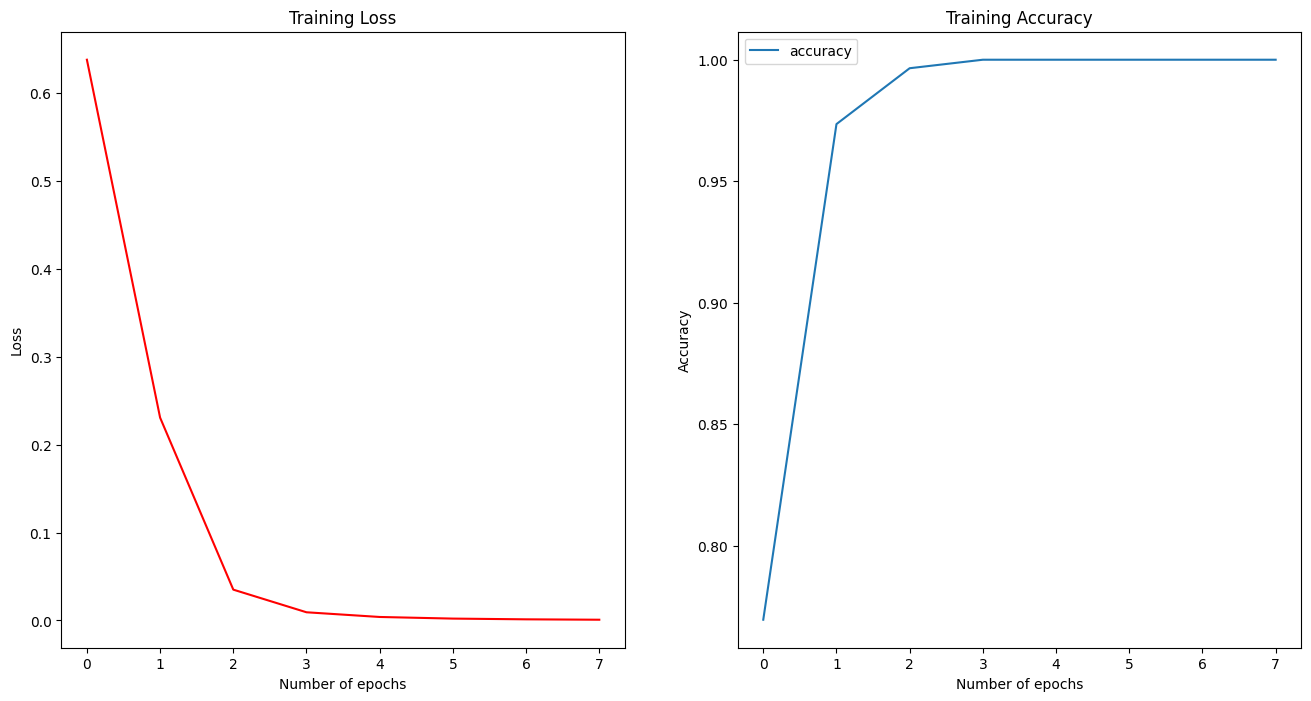

In [27]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='r',label='loss')
plt.title('Training Loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('Training Accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [28]:
model2 = Sequential()
model2.add(Dense(units=16, activation='relu', input_dim=x_train.shape[1]))
model2.add(Dense(units=8, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

Model compilation using sgd(Stochastic Gradient Descent) as the optimiser.

In [29]:
model2.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
history = model2.fit(x_train, y_train, batch_size=10, epochs=15)

Epoch 1/15
200/200 [==============================] - 5s 24ms/step - loss: 0.6929 - accuracy: 0.5200
Epoch 2/15
200/200 [==============================] - 6s 31ms/step - loss: 0.6917 - accuracy: 0.5200
Epoch 3/15
200/200 [==============================] - 5s 23ms/step - loss: 0.6908 - accuracy: 0.5200
Epoch 4/15
200/200 [==============================] - 4s 20ms/step - loss: 0.6896 - accuracy: 0.5200
Epoch 5/15
200/200 [==============================] - 5s 27ms/step - loss: 0.6884 - accuracy: 0.5200
Epoch 6/15
200/200 [==============================] - 5s 26ms/step - loss: 0.6871 - accuracy: 0.5200
Epoch 7/15
200/200 [==============================] - 5s 23ms/step - loss: 0.6858 - accuracy: 0.5200
Epoch 8/15
200/200 [==============================] - 5s 26ms/step - loss: 0.6841 - accuracy: 0.5200
Epoch 9/15
200/200 [==============================] - 6s 29ms/step - loss: 0.6823 - accuracy: 0.5275
Epoch 10/15
200/200 [==============================] - 4s 21ms/step - loss: 0.6804 - accura

In [31]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                3547328   
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3547473 (13.53 MB)
Trainable params: 3547473 (13.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


It shows that the test loss is greater than the first model and accuracy is too low.

In [32]:
test_loss, test_acc = model2.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

16/16 [==============================] - 1s 31ms/step - loss: 0.6782 - accuracy: 0.5400
Test loss: 0.6782286167144775
Test accuracy: 0.5400000214576721


### Model Saving

First model is saved as it is the better one.

In [35]:
save_model(model, 'movie_review.h5')

loaded_model = load_model('movie_review.h5')

<ipython-input-35-5c6164efc995>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'movie_review.h5')  # 'my_model.h5' is the filename


In [36]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                3547328   
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3547473 (13.53 MB)
Trainable params: 3547473 (13.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


A function is defined to predict the review using the model built.

In [53]:
def predict_sentiment(model, review):
    prediction = model.predict(np.expand_dims(review, axis=0))
    if prediction > 0.5:
        return "Positive"
    else:
        return "Negative"

In [54]:
review_to_test = x_test[0]
sentiment = predict_sentiment(loaded_model, review_to_test)
print(f"Sentiment: {sentiment}")


1/1 [==============================] - 0s 50ms/step
Sentiment: Negative


In [55]:
sentiment = predict_sentiment(loaded_model, x_test[2])
print(f"Sentiment: {sentiment}")

1/1 [==============================] - 0s 41ms/step
Sentiment: Positive
